In [ ]:
from google.colab import drive
import zipfile
import os

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/MyDrive/archive (4).zip"

Streaming output truncated to the last 5000 lines.
  inflating: ham10000_images_part_2/ISIC_0029325.jpg  
  inflating: ham10000_images_part_2/ISIC_0029326.jpg  
  inflating: ham10000_images_part_2/ISIC_0029327.jpg  
  inflating: ham10000_images_part_2/ISIC_0029328.jpg  
  inflating: ham10000_images_part_2/ISIC_0029329.jpg  
  inflating: ham10000_images_part_2/ISIC_0029330.jpg  
  inflating: ham10000_images_part_2/ISIC_0029331.jpg  
  inflating: ham10000_images_part_2/ISIC_0029332.jpg  
  inflating: ham10000_images_part_2/ISIC_0029333.jpg  
  inflating: ham10000_images_part_2/ISIC_0029334.jpg  
  inflating: ham10000_images_part_2/ISIC_0029335.jpg  
  inflating: ham10000_images_part_2/ISIC_0029336.jpg  
  inflating: ham10000_images_part_2/ISIC_0029337.jpg  
  inflating: ham10000_images_part_2/ISIC_0029338.jpg  
  inflating: ham10000_images_part_2/ISIC_0029339.jpg  
  inflating: ham10000_images_part_2/ISIC_0029340.jpg  
  inflating: ham10000_images_part_2/ISIC_0029341.jpg  
  inflating: h

In [ ]:
csv_path = "/content/HAM10000_metadata.csv"
img_folder1 = "/content/HAM10000_images_part_1/"
img_folder2 = "/content/HAM10000_images_part_2/"

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

In [ ]:
df = pd.read_csv(csv_path)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
def combine_paths(row):
    image_id = row['image_id']
    if os.path.exists(os.path.join(img_folder1, image_id + ".jpg")):
        return os.path.join(img_folder1, image_id + ".jpg")
    else:
        return os.path.join(img_folder2, image_id + ".jpg")

df['path'] = df.apply(combine_paths, axis=1)

In [ ]:
le = LabelEncoder()
df['label'] = le.fit_transform(df['dx'])
class_names = le.classes_

In [ ]:
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

In [ ]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])


In [ ]:
class SkinDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        img = Image.open(row['path']).convert("RGB")
        label = row['label']

        if self.transform:
            img = self.transform(img)

        return img, label

train_ds = SkinDataset(train_df, transform=train_transform)
val_ds = SkinDataset(val_df, transform=val_transform)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False)

In [ ]:
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(df['label']), y=df['label'])
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

In [ ]:
model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names))
model = model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [ ]:
best_acc = 0
for epoch in range(10):
    model.train()
    running_loss = 0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    scheduler.step()
    train_acc = 100 * correct / total
    print(f"Epoch {epoch+1}: Train Loss={running_loss:.4f}, Accuracy={train_acc:.2f}%")

Epoch 1: Train Loss=280.2567, Accuracy=58.41%
Epoch 2: Train Loss=209.6915, Accuracy=67.76%
Epoch 3: Train Loss=162.4340, Accuracy=73.32%
Epoch 4: Train Loss=144.7435, Accuracy=73.98%
Epoch 5: Train Loss=141.4667, Accuracy=75.24%
Epoch 6: Train Loss=123.9788, Accuracy=76.61%
Epoch 7: Train Loss=108.4323, Accuracy=79.08%
Epoch 8: Train Loss=76.0799, Accuracy=81.86%
Epoch 9: Train Loss=58.2979, Accuracy=85.83%
Epoch 10: Train Loss=52.2508, Accuracy=87.61%


In [ ]:
model.eval()
correct = 0
total = 0
all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

print(f"Validation Accuracy: {100 * correct / total:.2f}%")

Validation Accuracy: 84.32%



Classification Report:
              precision    recall  f1-score   support

       akiec       0.70      0.86      0.77        65
         bcc       0.70      0.87      0.78       103
         bkl       0.76      0.75      0.76       220
          df       0.53      0.87      0.66        23
         mel       0.56      0.75      0.64       223
          nv       0.96      0.87      0.91      1341
        vasc       0.79      0.96      0.87        28

    accuracy                           0.84      2003
   macro avg       0.72      0.85      0.77      2003
weighted avg       0.87      0.84      0.85      2003



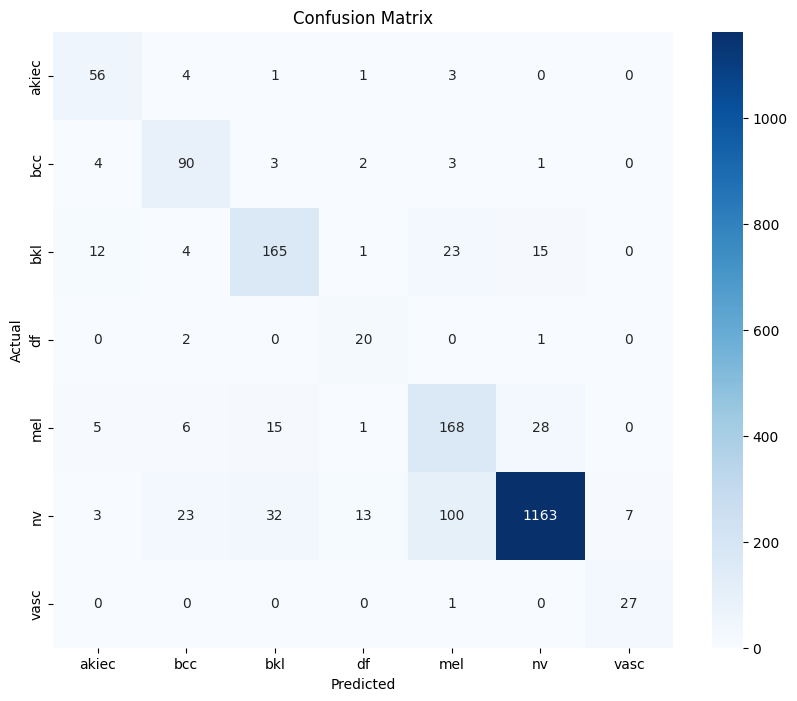

In [ ]:
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
torch.save(model.state_dict(), "/content/resnet_ham10000.pth")
print("Model saved to /content.")

Model saved to /content.


In [ ]:
def predict_image(image_path, model, transform, class_names):
    model.eval()
    image = Image.open(image_path).convert("RGB")
    img_tensor = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        outputs = model(img_tensor)
        _, predicted = torch.max(outputs, 1)
    predicted_class = class_names[predicted.item()]
    print(f"Predicted class: {predicted_class}")

    # Show image
    img_display = img_tensor.squeeze(0).cpu().permute(1, 2, 0)
    img_display = img_display * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])
    img_display = img_display.numpy().clip(0, 1)
    plt.imshow(img_display)
    plt.title(f"Predicted: {predicted_class}")
    plt.axis('off')
    plt.show()

Predicted class: bkl


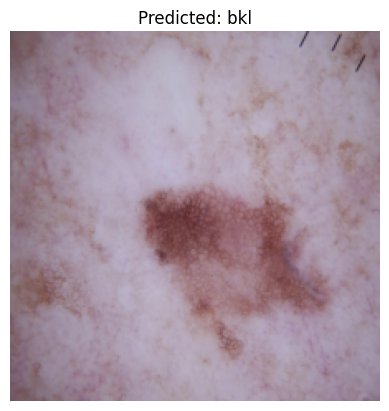

In [ ]:
sample_img_path = "/content/HAM10000_images_part_1/ISIC_0025083.jpg"  # Change path as needed
predict_image(sample_img_path, model, transform, class_names)